# Triton Sensors Point Cloud Sandbox

In [ ]:
JSON_PATH = "/Users/mohammedamin/Desktop/Projects/plextech/tritonsensors-plextech/example/sample_data/binData/11_09_2025_12_17_47/replay_1.json"   # <-- set me
RADAR_HEIGHT_M = 2.7              

In [120]:
import json
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt


In [121]:
def load_replay(json_path: str):
    with open(json_path, "r") as f:
        obj = json.load(f)
    frames = obj.get("data", [])
    if not isinstance(frames, list):
        raise ValueError("Expected obj['data'] to be a list of frames.")
    return obj, frames

json_path = Path(JSON_PATH)
if json_path.exists():
    replay_obj, frames = load_replay(str(json_path))
    print(f"Loaded file: {json_path}")

print(f"Frames: {len(frames)}")
print("Top-level keys:", list(replay_obj.keys())[:10])


Loaded file: /Users/mohammedamin/Desktop/Projects/plextech/tritonsensors-plextech/example/sample_data/binData/11_09_2025_12_17_47/replay_1.json
Frames: 960
Top-level keys: ['cfg', 'demo', 'device', 'data']


In [ ]:
def frame_to_df(frame, radar_height_m: float, use_first_n_cols: int = 5):
    """Convert one frame's pointCloud array to a DataFrame.

    Assumes columns: x, y, z, velocity, intensity in first 5 entries.
    Adds:
      - y_raw: original y
      - height: radar_height - y_raw
    """
    fd = frame.get("frameData", frame)  
    pc = np.asarray(fd.get("pointCloud", []), dtype=float)
    if pc.size == 0:
        return pd.DataFrame(columns=["x","y_raw","z","velocity","intensity","height"])
    if pc.ndim == 1:
        pc = pc.reshape(1, -1)

    n_cols = pc.shape[1]
    if n_cols < 3:
        raise ValueError(f"Point cloud has too few columns: {n_cols}")

    cols = ["x", "y_raw", "z", "velocity", "intensity"]
    use = min(use_first_n_cols, n_cols)
    base = pc[:, :use]
    df = pd.DataFrame(base, columns=cols[:use])

    # add extra columns (if any)
    for i in range(use, n_cols):
        df[f"extra_{i-use}"] = pc[:, i]

    if "y_raw" in df.columns:
        df["height"] = radar_height_m - df["y_raw"]
    else:
        df["height"] = np.nan
    return df

dfs = [frame_to_df(fr, RADAR_HEIGHT_M) for fr in frames]
sizes = [len(d) for d in dfs]
print(f"Points per frame (min/median/max): {np.min(sizes)} / {int(np.median(sizes))} / {np.max(sizes)}")


Points per frame (min/median/max): 13 / 76 / 151


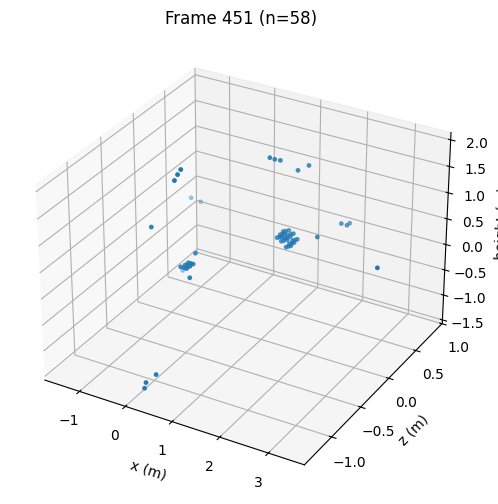

In [118]:
def plot_frame_3d(df, title="Frame"):
    if df.empty:
        print("Empty frame.")
        return
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(df["x"], df["z"], df["height"], s=6)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    ax.set_zlabel("height (m)")
    ax.set_title(title)
    plt.show()

frame_idx = 450
plot_frame_3d(dfs[frame_idx], title=f"Frame {frame_idx+1} (n={len(dfs[frame_idx])})")




DBSCAN parameters:
- `eps`: neighbor distance in meters
- `min_samples`: minimum points to form a dense region


Clusters: cluster
-1    15
 0    12
 1    31
Name: count, dtype: int64


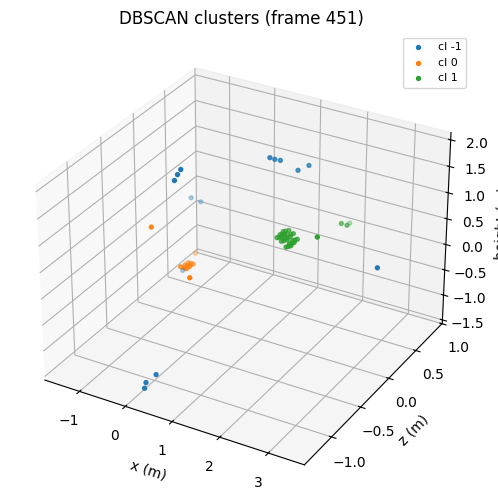

In [119]:
def dbscan_cluster_frame(df, eps=0.25, min_samples=10, use_cols=("x","z","height")):
    if df.empty:
        return df.copy(), np.array([], dtype=int)

    X = df.loc[:, list(use_cols)].to_numpy()
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X)

    out = df.copy()
    out["cluster"] = labels
    return out, labels

dfc, labels = dbscan_cluster_frame(dfs_f[frame_idx], eps=1, min_samples=12)
print("Clusters:", pd.Series(dfc["cluster"]).value_counts().sort_index())

def plot_clusters_3d(df, title="Clusters"):
    if df.empty:
        print("Empty frame.")
        return
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection="3d")
    for cl, grp in df.groupby("cluster"):
        ax.scatter(grp["x"], grp["z"], grp["height"], s=8, label=f"cl {cl}")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    ax.set_zlabel("height (m)")
    ax.set_title(title)
    ax.legend(loc="upper right", fontsize=8)
    plt.show()

plot_clusters_3d(dfc, title=f"DBSCAN clusters (frame {frame_idx+1})")


In [110]:
def compute_frame_features(df):
    """Return a dict of summary stats for one frame."""
    if df.empty:
        return dict(
            n_points=0,
            x_mean=np.nan, z_mean=np.nan, h_mean=np.nan,
            x_std=np.nan, z_std=np.nan, h_std=np.nan,
            h_min=np.nan, h_max=np.nan, h_range=np.nan,
            v_mean=np.nan, v_abs_mean=np.nan, v_abs_max=np.nan,
            inten_mean=np.nan, inten_max=np.nan
        )

    feats = {}
    feats["n_points"] = len(df)

    feats["x_mean"] = df["x"].mean()
    feats["z_mean"] = df["z"].mean()
    feats["h_mean"] = df["height"].mean()

    feats["x_std"]  = df["x"].std(ddof=0)
    feats["z_std"]  = df["z"].std(ddof=0)
    feats["h_std"]  = df["height"].std(ddof=0)

    feats["h_min"] = df["height"].min()
    feats["h_max"] = df["height"].max()
    feats["h_range"] = feats["h_max"] - feats["h_min"]

    if "velocity" in df.columns:
        feats["v_mean"] = df["velocity"].mean()
        feats["v_abs_mean"] = df["velocity"].abs().mean()
        feats["v_abs_max"] = df["velocity"].abs().max()
    else:
        feats["v_mean"] = np.nan
        feats["v_abs_mean"] = np.nan
        feats["v_abs_max"] = np.nan

    if "intensity" in df.columns:
        feats["inten_mean"] = df["intensity"].mean()
        feats["inten_max"] = df["intensity"].max()
    else:
        feats["inten_mean"] = np.nan
        feats["inten_max"] = np.nan

    return feats

features = pd.DataFrame([compute_frame_features(d) for d in dfs_f])
features.insert(0, "frame_idx", np.arange(len(features)))
features.head()


,frame_idx,n_points,x_mean,z_mean,h_mean,x_std,z_std,h_std,h_min,h_max,h_range,v_mean,v_abs_mean,v_abs_max,inten_mean,inten_max
0,0,88,-0.138809,-1.501863,0.746215,0.113284,1.063270,0.475996,-0.028077,1.638350,1.666427,0.005170,0.124864,0.39452,31.226363,81.519998
1,1,76,-0.203630,-1.725560,0.933117,0.135600,1.479027,0.488219,-1.197113,1.610679,2.807792,0.076388,0.193517,0.53536,51.754209,165.239996
2,2,77,-0.177055,-1.134578,0.808756,0.113192,0.886927,0.461718,-0.093655,1.573768,1.667423,-0.142673,0.176382,0.59164,20.189090,31.999999
3,3,79,-0.027479,-1.228154,1.146093,0.189273,0.948388,0.454099,-1.362844,1.754584,3.117428,-0.024977,0.099882,0.45080,24.688101,46.879999
4,4,107,-0.075650,-0.627010,1.244324,0.171026,1.474152,0.497675,-0.045178,1.727439,1.772617,-0.149797,0.164541,0.28168,17.469158,30.639999


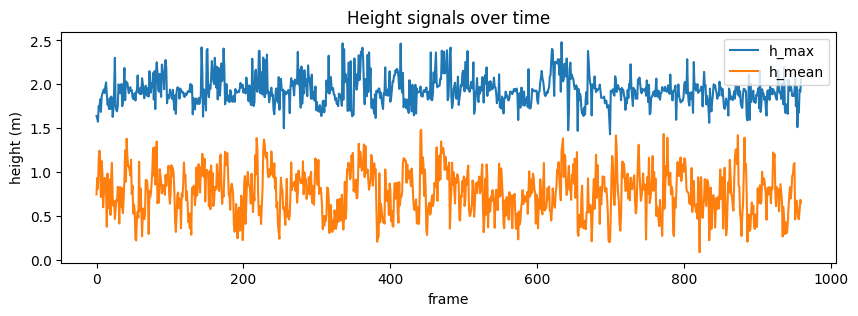

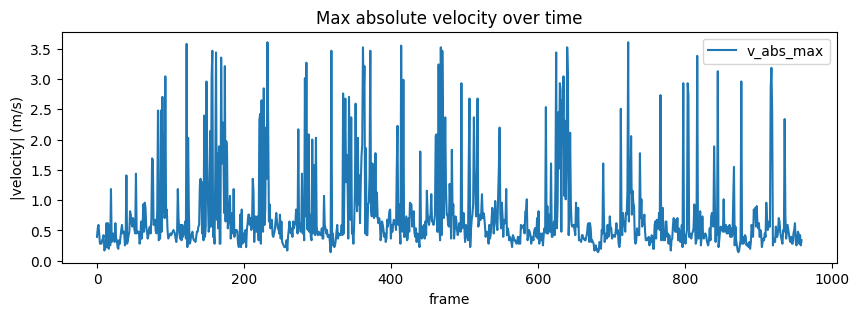

In [111]:
plt.figure(figsize=(10,3))
plt.plot(features["frame_idx"], features["h_max"], label="h_max")
plt.plot(features["frame_idx"], features["h_mean"], label="h_mean")
plt.xlabel("frame")
plt.ylabel("height (m)")
plt.title("Height signals over time")
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(features["frame_idx"], features["v_abs_max"], label="v_abs_max")
plt.xlabel("frame")
plt.ylabel("|velocity| (m/s)")
plt.title("Max absolute velocity over time")
plt.legend()
plt.show()


In [ ]:
WINDOW = 8  # frames

def add_window_features(df, window=8):
    out = df.copy()

    out["h_max_delta"] = out["h_max"].diff()

    roll = out.rolling(window=window, min_periods=1)
    out["h_max_min_w"] = roll["h_max"].min()
    out["h_max_max_w"] = roll["h_max"].max()
    out["h_mean_min_w"] = roll["h_mean"].min()
    out["h_mean_max_w"] = roll["h_mean"].max()

    out["v_abs_max_max_w"] = roll["v_abs_max"].max()
    out["v_abs_mean_mean_w"] = roll["v_abs_mean"].mean()

    LOW_H_MAX = 0.7 
    out["low_height_frac_w"] = roll["h_max"].apply(lambda s: np.mean(s < LOW_H_MAX), raw=False)

    return out

features_w = add_window_features(features, window=WINDOW)
features_w.head(12)


,frame_idx,n_points,x_mean,z_mean,h_mean,x_std,z_std,h_std,h_min,h_max,...,inten_mean,inten_max,h_max_delta,h_max_min_w,h_max_max_w,h_mean_min_w,h_mean_max_w,v_abs_max_max_w,v_abs_mean_mean_w,low_height_frac_w
0,0,88,-0.138809,-1.501863,0.746215,0.113284,1.063270,0.475996,-0.028077,1.638350,...,31.226363,81.519998,NaN,1.638350,1.638350,0.746215,0.746215,0.39452,0.124864,0.0
1,1,76,-0.203630,-1.725560,0.933117,0.135600,1.479027,0.488219,-1.197113,1.610679,...,51.754209,165.239996,-0.027671,1.610679,1.638350,0.746215,0.933117,0.53536,0.159190,0.0
2,2,77,-0.177055,-1.134578,0.808756,0.113192,0.886927,0.461718,-0.093655,1.573768,...,20.189090,31.999999,-0.036912,1.573768,1.638350,0.746215,0.933117,0.59164,0.164921,0.0
3,3,79,-0.027479,-1.228154,1.146093,0.189273,0.948388,0.454099,-1.362844,1.754584,...,24.688101,46.879999,0.180816,1.573768,1.754584,0.746215,1.146093,0.59164,0.148661,0.0
4,4,107,-0.075650,-0.627010,1.244324,0.171026,1.474152,0.497675,-0.045178,1.727439,...,17.469158,30.639999,-0.027145,1.573768,1.754584,0.746215,1.244324,0.59164,0.151837,0.0
5,5,46,-0.053142,-1.141230,1.139393,0.422763,0.728569,0.547444,-0.504339,1.828592,...,11.644348,16.520000,0.101153,1.573768,1.828592,0.746215,1.244324,0.59164,0.153476,0.0
6,6,49,0.173767,-1.102498,0.715947,0.148004,0.676964,0.631881,-0.754887,1.685551,...,14.981224,23.759999,-0.143041,1.573768,1.828592,0.715947,1.244324,0.59164,0.146501,0.0
7,7,77,0.288050,-0.861437,1.125372,0.137828,0.414076,0.735519,-1.283650,1.859509,...,15.844675,21.640000,0.173958,1.573768,1.859509,0.715947,1.244324,0.59164,0.155399,0.0
8,8,103,0.233366,-0.275601,1.003891,0.340450,0.977969,0.726707,-0.732072,1.895399,...,17.287767,30.879999,0.035890,1.573768,1.895399,0.715947,1.244324,0.59164,0.163348,0.0
9,9,62,0.195989,-0.074244,0.599302,0.468145,1.116349,0.697963,-0.173813,1.919185,...,14.294838,26.879999,0.023787,1.573768,1.919185,0.599302,1.244324,0.59164,0.152221,0.0
